In [1]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [2]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt

In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_bert_features.csv") #train data
test_data = pd.read_csv("acp_test_bert_features.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Define the AdaBoost model and hyperparameter grid
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=42) #base_estimator=base_estimator means use the DecisionTreeClassifier as the base estimator

param_grid = {
    'n_estimators': [50, 200, 400, 500, 600, 800, 1000],               # Number of weak learners, default is 50, range is 10 to 1000
    'learning_rate': [0.01, 0.1, 1.0],            # Controls contribution of each weak learner, default is 1.0, range is 0.01 to 1.0
    'algorithm': ['SAMME'],            # Adaptive boosting algorithm, default is SAMME.R, range is SAMME and SAMME.R; SAMME is equivalent to AdaBoost, SAMME.R is generally faster and often performs better for classification tasks.
    'estimator__max_depth': [1, 3, 5, 7, 9],       # Depth of the decision tree base estimator, default is 1, range is 1 to 10
    'estimator__max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
}
# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=5,
    verbose=2,
)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Save best hyperparameters to a file
with open('best_model_info_adaboost_protbert.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_adaboost_protbert.txt'")

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=200; total time=   1.3s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__max_features=sqrt, learning_rate=0.01, n_estimators=200; t

In [5]:
# Step 6: Use the best model from GridSearchCV
best_adaboost_model = grid_search.best_estimator_

#save best model to a file
joblib.dump(best_adaboost_model, "best_adaboost_protbert_model.pkl")

['best_adaboost_protbert_model.pkl']

In [6]:
# Step 8: Fit the model on the training data
best_adaboost_model.fit(X_train, y_train)

# Evaluate on the test dataset
y_test_pred = best_adaboost_model.predict(X_test)
y_test_prob = best_adaboost_model.predict_proba(X_test)[:, 1]

# Calculate and print accuracy, classification reports, and confusion matrices
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"adaboost Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

adaboost Test Accuracy: 80.00%
Confusion Matrix (Test Data):
 [[71 20]
 [17 77]]
Test Data - Sensitivity: 0.8191489361702128 Specificity: 0.7802197802197802


In [7]:
print("Confusion Matrix (Test Data):")
print(f"TN: {confusion_matrix_test[0,0]}  FP: {confusion_matrix_test[0,1]}")
print(f"FN: {confusion_matrix_test[1,0]}  TP: {confusion_matrix_test[1,1]}")

Confusion Matrix (Test Data):
TN: 71  FP: 20
FN: 17  TP: 77


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)

Precision: 0.7938144329896907
F1 Score: 0.806282722513089
Matthews Correlation Coefficient (MCC): 0.6000003327993741


Test Data ROC AUC: 0.8584288052373158
Test Data FPR: [0.         0.         0.         0.01098901 0.01098901 0.02197802
 0.02197802 0.03296703 0.03296703 0.04395604 0.04395604 0.05494505
 0.05494505 0.06593407 0.06593407 0.07692308 0.07692308 0.0989011
 0.0989011  0.10989011 0.10989011 0.13186813 0.13186813 0.14285714
 0.14285714 0.15384615 0.15384615 0.16483516 0.16483516 0.17582418
 0.17582418 0.18681319 0.18681319 0.1978022  0.1978022  0.21978022
 0.21978022 0.24175824 0.24175824 0.26373626 0.26373626 0.37362637
 0.37362637 0.3956044  0.3956044  0.41758242 0.41758242 0.45054945
 0.45054945 0.46153846 0.46153846 0.49450549 0.49450549 0.65934066
 0.65934066 0.7032967  0.7032967  0.85714286 0.85714286 0.93406593
 0.93406593 1.        ]
Test Data TPR: [0.         0.0106383  0.25531915 0.25531915 0.26595745 0.26595745
 0.31914894 0.31914894 0.35106383 0.35106383 0.39361702 0.39361702
 0.42553191 0.42553191 0.46808511 0.46808511 0.5212766  0.5212766
 0.53191489 0.53191489 0.54255319 0.542

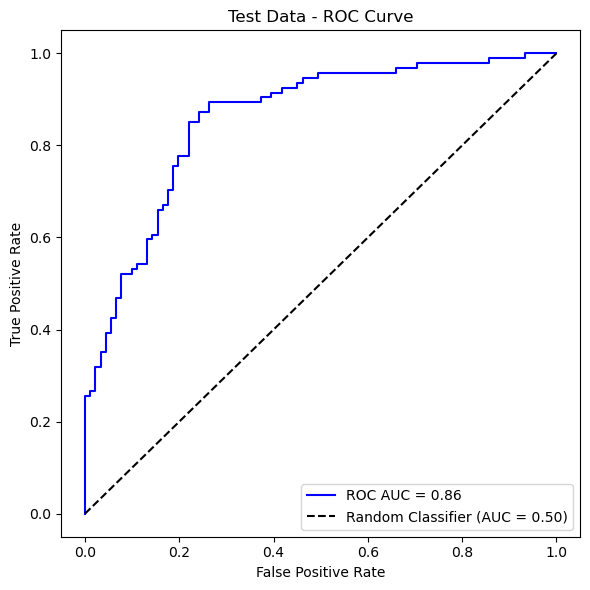

In [9]:
# Evaluate on the test dataset
y_test_pred = best_adaboost_model.predict(X_test)
y_test_prob = best_adaboost_model.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("adaboost_protbert_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'adaboost_protbert_roc_auc_curve.png'.")

# Show the plot
plt.show()

In [10]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_adaboost_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_adaboost_protbert.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_adaboost_protbert.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.72972973 0.87837838 0.78378378 0.7972973  0.83783784 0.77027027
 0.91891892 0.75675676 0.80821918 0.84931507]
Mean 10-Fold CV Accuracy: 0.8130507219548317
Accuracy of each fold has been saved to 'cv_accuracies_adaboost_protbert.txt'


Mean Accuracy: 81.31
Mean AUC: 1.0000


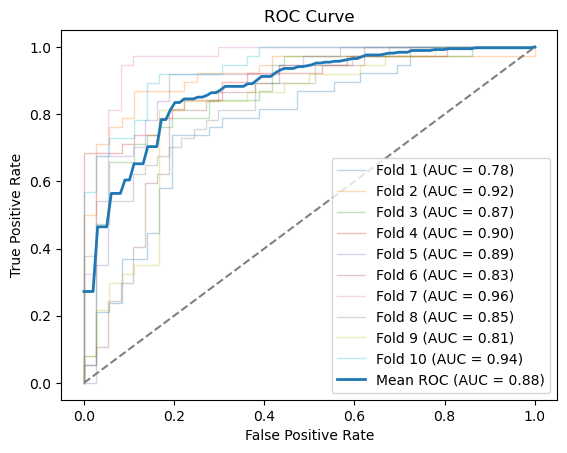

In [11]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_adaboost_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_adaboost_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_adaboost_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_adaboost_protbert.png", dpi=500)
plt.show()